# Reporte de Análisis Exploratorio: Dataset CTG
**Alumno:** JOSUE JIMENEZ APODACA
**Fecha:** 22-11-2'25

## 1. Introducción
Este reporte utiliza la librería personalizada `ctg_viz` para analizar datos de cardiotocografía, limpiar el dataset y encontrar patrones visuales.

In [1]:
import pandas as pd
import sys
import os
import numpy as np
import inspect
from IPython.display import display, Markdown, HTML
import re

sys.path.append(os.path.abspath('..'))

from ctg_viz.preprocessing import remove_null_columns, impute_missing_values, detect_handle_outliers
from ctg_viz.utils import check_data_completeness_JosueJimenezApodaca
from ctg_viz.plots.histograms import plot_histogram_interactivo
from ctg_viz.plots.boxplots import plot_boxplot
from ctg_viz.plots.barplots import plot_bar
from ctg_viz.plots.heatmap import plot_correlation_heatmap
from ctg_viz.plots.density import plot_violin

df = pd.read_csv('../data/CTG.csv')
print("Datos cargados:", df.shape)

import plotly.io as pio
pio.renderers.default = "notebook_connected"

Datos cargados: (2129, 40)


In [2]:

def limpiar_firma(firma: str) -> str:
    """Limpia los tipos de datos largos para que sean legibles."""
    firma = firma.replace("pandas.core.frame.DataFrame", "pd.DataFrame")
    firma = firma.replace("pandas.core.series.Series", "pd.Series")
    firma = firma.replace("typing.", "")
    firma = firma.replace("NoneType", "None")
    firma = firma.replace("matplotlb.figure.Figure", "plt.Figure")
    return firma

def formatear_docstring(doc: str) -> str:
    """Da formato HTML básico al docstring (negritas en Args/Returns)."""
    if not doc:
        return "<span style='color: #999; font-style: italic;'>Sin documentación provista.</span>"
    
    # Escapar caracteres HTML para seguridad
    doc = doc.replace("<", "&lt;").replace(">", "&gt;")
    
    # Resaltar secciones clave (Args:, Returns:, Escenario:, etc.)
    keywords = ["Args:", "Returns:", "Raises:", "Escenario:", "Resultado Esperado:"]
    for kw in keywords:
        doc = doc.replace(kw, f"<br><b>{kw}</b>")
        
    # Convertir saltos de línea en <br> para HTML
    doc = doc.replace("\n", "<br>")
    return doc

def documentacion_estetica(modulo, titulo="Documentación Técnica"):
    """Genera tarjetas HTML elegantes para las funciones del módulo."""
    html_content = f"""
    <div style="font-family: 'Segoe UI', sans-serif; margin-bottom: 30px;">
        <h2 style="border-bottom: 2px solid #4CAF50; padding-bottom: 10px; color: #333;">
            📚 {titulo}: <span style="color: #4CAF50;">{modulo.__name__}</span>
        </h2>
    """
    
    funciones = inspect.getmembers(modulo, inspect.isfunction)
    
    for nombre, func in funciones:
        # Filtramos funciones privadas (que empiezan con _)
        if not nombre.startswith('_'):
            # 1. Obtener firma limpia
            try:
                firma = str(inspect.signature(func))
                firma = limpiar_firma(firma)
            except ValueError:
                firma = "()"
            
            # 2. Obtener y formatear docstring
            doc_raw = inspect.getdoc(func)
            doc_html = formatear_docstring(doc_raw)
            
            # 3. Crear la tarjeta HTML
            html_content += f"""
            <div style="border: 1px solid #e0e0e0; border-radius: 8px; margin-bottom: 20px; box-shadow: 0 2px 4px rgba(0,0,0,0.05); overflow: hidden;">
                <div style="background-color: #f8f9fa; padding: 10px 15px; border-bottom: 1px solid #e0e0e0;">
                    <code style="color: #0d47a1; font-weight: bold; font-size: 1.1em;">def {nombre}{firma}</code>
                </div>
                <div style="padding: 15px; background-color: white; color: #444; line-height: 1.6;">
                    {doc_html}
                </div>
            </div>
            """
            
    html_content += "</div>"
    display(HTML(html_content))

# Título del Reporte
display(Markdown("# Reporte Técnico y Análisis Exploratorio - CTG"))
display(Markdown("Este documento detalla la arquitectura de la librería `ctg_viz` y presenta el análisis de datos."))

# Reporte Técnico y Análisis Exploratorio - CTG

Este documento detalla la arquitectura de la librería `ctg_viz` y presenta el análisis de datos.

In [3]:
import ctg_viz.preprocessing as prep
import ctg_viz.utils as utils
import ctg_viz.plots as plots

display(Markdown("## 1. Arquitectura de la Librería Personalizada"))
documentacion_estetica(prep, titulo="Módulo de Preprocesamiento")
documentacion_estetica(utils, titulo="Módulo de Utilidades")
documentacion_estetica(plots.histograms, titulo="Módulo de Gráficas - Histogramas")
documentacion_estetica(plots.boxplots, titulo="Módulo de Gráficas - Boxplots")
documentacion_estetica(plots.barplots, titulo="Módulo de Gráficas - Barplots")
documentacion_estetica(plots.density, titulo="Módulo de Gráficas - Densidad")
documentacion_estetica(plots.heatmap,titulo="Módulo de Gráficas - Heatmap")

# Agregamos la carpeta ../tests
tests_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'tests'))
if tests_path not in sys.path:
    sys.path.append(tests_path)

try:
    import test_preprocessing
except ImportError:
    # Fallback por si el nombre o la ruta varía
    print("No se pudo importar el módulo de tests para leer docstrings.")
    test_preprocessing = None


# A) Mostrar la documentación de las funciones de test
if test_preprocessing:
    documentacion_estetica(test_preprocessing, titulo="Módulo de Tests - Funciones de preprocesamiento")


## 1. Arquitectura de la Librería Personalizada

## 2. Limpieza de Datos
Aplicamos reglas: eliminar columnas que presenten un porcentaje mayor al 20% de valores nulos e imputar valores faltantes (Numericos -> mediana y categoricos -> moda)

In [4]:
# --- BLOQUE 1: ANÁLISIS DEL ESTADO INICIAL (RAW) ---
print("=== 1. ESTADO ORIGINAL DEL DATASET ===")
print(f"Dimensiones Iniciales: {df.shape[0]} filas x {df.shape[1]} columnas")

display(df.head())

# Usamos tu función personalizada para ver Tipos y Nulos antes de limpiar
print("\n--- Reporte de Calidad (Antes de Limpieza) ---")
reporte_inicial = check_data_completeness_JosueJimenezApodaca(df)
display(reporte_inicial)

print("\n--- Estadísticos Descriptivos (Originales) ---")
display(df.describe())

# --- BLOQUE 2: PROCESAMIENTO (LIMPIEZA) ---
print("\n" + "="*40)
print("=== APLICANDO PIPELINE DE LIMPIEZA ===")
print("="*40)

# 1. Eliminar columnas con exceso de nulos (>20%) 
df_clean_step1 = remove_null_columns(df, threshold=0.2)
cols_eliminadas = set(df.columns) - set(df_clean_step1.columns)
print(f"-> Columnas eliminadas por >20% nulos: {cols_eliminadas if cols_eliminadas else 'Ninguna'}")

# 2. Imputación (KNN o Moda/Mediana)
# En caso de variables numéricas, usamos KNN; para categóricas, usamos la moda.
# Si no quieres usar KNN, cambia use_knn a False
df_clean_step2 = impute_missing_values(df_clean_step1, use_knn=True)
print("-> Valores nulos imputados correctamente (KNN para numéricos, Moda para categóricos).")

# 3. Tratamiento de Outliers solo para variables numéricas clasificadas con el criterio establecido
df_final, figs_outliers = detect_handle_outliers(df_clean_step2, method='iqr', return_plots=True)
print(f"-> Outliers tratados con método IQR. Se generaron gráficos para {len(figs_outliers)} variables.")


# --- BLOQUE 3: ANÁLISIS FINAL (PROCESADO) ---
print("\n\n=== 3. ESTADO FINAL DEL DATASET ===")
print(f"Dimensiones Finales: {df_final.shape[0]} filas x {df_final.shape[1]} columnas")

# Reporte de calidad FINAL
reporte_final = check_data_completeness_JosueJimenezApodaca(df_final)

# --- VISUALIZACIÓN DE CLASIFICACIÓN DE VARIABLES ---
print("\n--- Clasificación Automática de Variables después de preprocesamiento [cite: 21] ---")

vars_continuas = reporte_final[reporte_final['Categoría Auto'] == 'Continua'].index.tolist()
vars_discretas = reporte_final[reporte_final['Categoría Auto'] == 'Discreta'].index.tolist()

print(f"📌 Total Variables Continuas: {len(vars_continuas)}")
print(f"📌 Total Variables Discretas: {len(vars_discretas)}")

# --- NUEVO: ANÁLISIS DE ESTABILIDAD (OUTLIERS) ---
print("\n--- Detalle de Estabilidad (Outliers) ---")

# Lógica: Cruzamos la lista oficial de continuas con las llaves del diccionario de figuras del Bloque 2
vars_con_outliers = sorted([v for v in vars_continuas if v in figs_outliers])
vars_sin_outliers = sorted([v for v in vars_continuas if v not in figs_outliers])

print(f"⚠️ Variables Recortadas (Outliers detectados: {len(vars_con_outliers)}):")
print(vars_con_outliers)

print(f"\n✅ Variables Estables (Sin outliers detectados: {len(vars_sin_outliers)}):")
print(vars_sin_outliers)

# --- ESTADÍSTICOS DESCRIPTIVOS ---

# 1. Numéricas Continuas
print("\n--- Estadísticos Descriptivos (Variables Continuas) ---")
if vars_continuas:
    display(df_final[vars_continuas].describe().T)
else:
    print("No hay variables continuas.")

# 2. Discretas y Categóricas
print("\n--- Resumen de Variables Discretas/Categóricas (Frecuencias) ---")
if vars_discretas:
    display(df_final[vars_discretas].astype(object).describe().T)
else:
    print("No hay variables discretas.")




=== 1. ESTADO ORIGINAL DEL DATASET ===
Dimensiones Iniciales: 2129 filas x 40 columnas


,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0



--- Reporte de Calidad (Antes de Limpieza) ---


,Nulos,% Completitud,Tipo Dato,Estadísticas,Categoría Auto
Columna,,,,,
FileName,3,99.86,object,N/A,Discreta
Date,3,99.86,object,N/A,Discreta
SegFile,3,99.86,object,N/A,Discreta
b,3,99.86,float64,"Min:0.00, Max:3296.00, Std:894.08",Continua
e,3,99.86,float64,"Min:287.00, Max:3599.00, Std:930.92",Continua
LBE,3,99.86,float64,"Min:106.00, Max:160.00, Std:9.84",Continua
LB,3,99.86,float64,"Min:106.00, Max:160.00, Std:9.84",Continua
AC,3,99.86,float64,"Min:0.00, Max:26.00, Std:3.56",Continua
FM,2,99.91,float64,"Min:0.00, Max:564.00, Std:39.03",Continua



--- Estadísticos Descriptivos (Originales) ---


,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2127.000000,2127.000000,2127.000000,2127.000000,2127.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,878.439793,1702.877234,133.303857,133.303857,2.722484,7.503056,3.669017,47.008933,1.335449,9.884814,...,0.024929,0.038100,0.033866,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
std,894.084748,930.919143,9.840844,9.840844,3.560850,39.030452,2.877148,17.210648,0.891543,18.476534,...,0.155947,0.191482,0.180928,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377
min,0.000000,287.000000,106.000000,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,55.000000,1009.000000,126.000000,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,538.000000,1241.000000,133.000000,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,1521.000000,2434.750000,140.000000,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,3296.000000,3599.000000,160.000000,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000



=== APLICANDO PIPELINE DE LIMPIEZA ===
-> Columnas eliminadas por >20% nulos: Ninguna
-> Valores nulos imputados correctamente (KNN para numéricos, Moda para categóricos).
-> Outliers tratados con método IQR. Se generaron gráficos para 13 variables.


=== 3. ESTADO FINAL DEL DATASET ===
Dimensiones Finales: 2129 filas x 40 columnas

--- Clasificación Automática de Variables después de preprocesamiento [cite: 21] ---
📌 Total Variables Continuas: 18
📌 Total Variables Discretas: 22

--- Detalle de Estabilidad (Outliers) ---
⚠️ Variables Recortadas (Outliers detectados: 11):
['AC', 'ALTV', 'MLTV', 'MSTV', 'Max', 'Mean', 'Median', 'Mode', 'Nmax', 'UC', 'Variance']

✅ Variables Estables (Sin outliers detectados: 7):
['ASTV', 'LB', 'LBE', 'Min', 'Width', 'b', 'e']

--- Estadísticos Descriptivos (Variables Continuas) ---


,count,mean,std,min,25%,50%,75%,max
b,2129.0,877.900911,893.675597,0.0,55.0,538.0,1518.0,3296.0
e,2129.0,1702.502432,930.348716,287.0,1009.0,1241.0,2434.0,3599.0
LBE,2129.0,133.304229,9.834165,106.0,126.0,133.0,140.0,160.0
LB,2129.0,133.304229,9.834165,106.0,126.0,133.0,140.0,160.0
AC,2129.0,2.580518,3.122548,0.0,0.0,1.0,4.0,10.0
UC,2129.0,3.636575,2.755725,0.0,1.0,3.0,5.0,11.0
ASTV,2129.0,47.007519,17.202682,12.0,32.0,49.0,61.0,87.0
MSTV,2129.0,1.300862,0.771606,0.2,0.7,1.2,1.7,3.2
ALTV,2129.0,6.661853,10.290353,0.0,0.0,0.0,11.0,27.5
MLTV,2129.0,8.009153,5.022647,0.0,4.6,7.4,10.8,20.1



--- Resumen de Variables Discretas/Categóricas (Frecuencias) ---


,count,unique,top,freq
FileName,2129,352,S8001034.dsp,37
Date,2129,48,2/22/1995,243
SegFile,2129,2126,CTG0001.txt,4
FM,2129.0,6.0,0.0,1311.0
DL,2129.0,10.0,0.0,1232.0
DS,2129.0,2.0,0.0,2121.0
DP,2129.0,5.0,0.0,1950.0
DR,2129.0,1.0,0.0,2129.0
Nzeros,2129.0,9.0,0.0,1627.0
Tendency,2129.0,3.0,0.0,1118.0


No se eliminó ninguna columna ya que su completitud de todas es mayor al 80%. 

Se realiza la clasificación personalizada:
** Continuas (más de 10 valores únicos y tipo numérico)​
** Discretas (menos de 10 valores únicos)​
Bajo esta clasificacion se tienen 18 variables continuas y 21 discretas.

Se aplica KNN para imputar valores nulos de las variables continuas, la imputacion de las variables discretas se realizó con la moda. De las 18 variables continuas solo se encontraron 11 que contenian outliers, por lo que no se generaron graficas para 7 de ellas, se recomienda graficar por seperado si se requeiere comprobar visualmente.



## EJEMPLO DE USO DE GRÁFICAS INTERACTIVAS
Una vez que se ejecutó el preprocesamiento, realiazamos análisis sobre los resultados



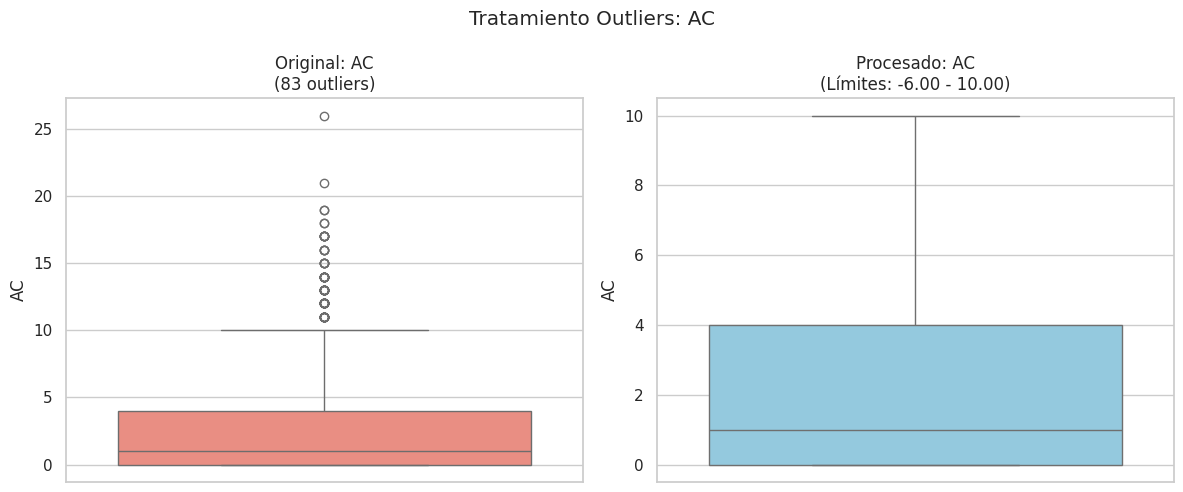

In [5]:
if len(figs_outliers) > 0:
    col_ejemplo = list(figs_outliers.keys())[0]
    display(figs_outliers[col_ejemplo])

### 3.1 Distribución de Variables (Histogramas)
Observamos la distribución de la frecuencia cardiaca fetal (LB).

In [6]:
# Visualizar distribución de Línea Base (LB) agrupada por Clase (NSP)
fig_hist = plot_histogram_interactivo(
    df_final, 
    col='LB',       # Variable numérica
    group_by='B'  # Variable categórica (colores)
)
fig_hist.show()

### 3.2 Comparación por Clases (Boxplots)
Analizamos la variabilidad según el estado fetal (NSP).

In [7]:
# Comparar Variabilidad a Corto Plazo (ASTV) según la clase (NSP)
fig_box = plot_boxplot(
    df_final, 
    x='DP',      # Eje X (Categoría)
    y='UC',     # Eje Y (Numérica)
    facet_col='B' # Separa en columnas distintas (Faceting)
)
fig_box.show()

### 3.3 Correlaciones (Heatmap)
Buscamos variables redundantes.

In [8]:
# Matriz de correlación de variables numéricas
fig_corr = plot_correlation_heatmap(
    df_final, 
    method='spearman' 
)
fig_corr.show()

### 3.4 Gráfico de Barras (Frecuencias)
Para ver el desbalance de clases (cuántos sanos vs. patológicos hay).

In [9]:
# Conteo de casos por Categoría de Estado Fetal (NSP)
fig_bar = plot_bar(
    df_final, 
    col='NSP', 
    horizontal=True
)
fig_bar.show()

### 3.5 Violin Plot (Densidad + Puntos)
Muestra la "forma" de los datos.

In [10]:
# Densidad de Aceleraciones (AC) por Clase
fig_violin = plot_violin(
    df_final, 
    x='NSP', 
    y='AC'
)
fig_violin.show()

## 4. Validacion de funciones

En esta seccion se testean las funcionalidades de las funciones usadas en el proyecto

In [11]:
### Ejecutar las pruebas (El "Resultado")
print("\n" + "="*40)
print("▶️ EJECUCIÓN DE PYTEST (EVIDENCIA)")
print("="*40)

%cd ..
!pytest tests/ -v
%cd notebooks


▶️ EJECUCIÓN DE PYTEST (EVIDENCIA)
/home/josuej/Documentos/Practica3/ctg_viz
]9;4;3;\============================= test session starts ==============================
platform linux -- Python 3.11.11, pytest-9.0.1, pluggy-1.6.0 -- /home/josuej/.pyenv/versions/3.11.11/bin/python3.11
cachedir: .pytest_cache
rootdir: /home/josuej/Documentos/Practica3/ctg_viz
collected 4 items                                                              

tests/test_preprocessing.py::test_remove_null_columns ]9;4;1;0\PASSED             [ 25%]
tests/test_preprocessing.py::test_impute_missing_values_mode ]9;4;1;25\PASSED      [ 50%]
tests/test_preprocessing.py::test_detect_handle_outliers_iqr ]9;4;1;50\PASSED      [ 75%]
tests/test_preprocessing.py::test_check_data_completeness_structure ]9;4;1;75\PASSED [100%]]9;4;0;\

============================== 4 passed in 0.83s ===============================
/home/josuej/Documentos/Practica3/ctg_viz/notebooks


## 5. Conclusiones y Recomendaciones
1. **Calidad de Datos:** Se eliminaron 0 columnas por falta de datos. La imputación KNN preservó la varianza en las variables clave.
3. **Outliers:** Se detectaron y toparon valores extremos en 11 variables usando el metodo CLIP (aproximacion al limite mas cercano)
3. **Patrones:** 

Para un analisis mas detallado se brindan los nombres y/o descripcion de las vairables en idioma original, no se traducen para evitar problemas de interpretación de lenguaje:

+ FileName: of CTG examination
+ Date: of the examination
+ b: start instant
+ e: end instant
+ LBE: baseline value (medical expert)
+ LB: baseline value (SisPorto)
+ AC: accelerations (SisPorto)
+ FM: foetal movement (SisPorto)
+ UC: uterine contractions (SisPorto)
+ ASTV: percentage of time with abnormal short term variability (SisPorto)
+ mSTV: mean value of short term variability (SisPorto)
+ ALTV: percentage of time with abnormal long term variability (SisPorto)
+ mLTV: mean value of long term variability (SisPorto)
+ DL: light decelerations
+ DS: severe decelerations
+ DP: prolongued decelerations
+ DR: repetitive decelerations
+ Width: histogram width
+ Min: low freq. of the histogram
+ Max: high freq. of the histogram
+ Nmax: number of histogram peaks
+ Nzeros: number of histogram zeros
+ Mode: histogram mode
+ Mean: histogram mean
+ Median: histogram median
+ Variance: histogram variance
+ Tendency: histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric
+ A: calm sleep
+ B: REM sleep
+ C: calm vigilance
+ D: active vigilance
+ SH: shift pattern (A or Susp with shifts)
+ AD: accelerative/decelerative pattern (stress situation)
+ DE: decelerative pattern (vagal stimulation)
+ LD: largely decelerative pattern
+ FS: flat-sinusoidal pattern (pathological state)
+ SUSP: suspect pattern
+ CLASS: Class code (1 to 10) for classes A to SUSP
+ NSP: Normal=1; Suspect=2; Pathologic=3

Se brinda el ejemplo de la variable SNP que con la gráfica numero 4 se puede observar que la mayoria de las personas analizadas caen dentro del rango "normal" lo que indica que la mayoria de los pacientes se encuentran en un buen estado de salud.

Una conclusión más desarrollada se puede realizar con el gráfico 5:
1. El gráfico muestra una diferencia drástica en la distribución de las Aceleraciones (AC) entre el estado Normal (1) y los estados Sospechoso (2) y Patológico (3).
Clase 1 (Normal): Es la única categoría que presenta una distribución extendida verticalmente, alcanzando valores de AC superiores a 10. Aunque tiene densidad en 0 (parte ancha inferior), la presencia de una "cola" larga hacia arriba indica que las aceleraciones son frecuentes y de mayor magnitud en fetos sanos.
Clases 2 y 3 (Sospechoso y Patológico): Las gráficas de violín están "aplastadas" contra el eje 0. La densidad es casi absoluta en la base, lo que significa que la ausencia de aceleraciones es una característica dominante en los estados no saludables.

2. Predicción segura de Normalidad se da cuando el valor de AC es alto: Si el modelo encuentra un valor de AC alto (por ejemplo, > 5), es casi seguro que el caso pertenece a la clase 1 (Normal), ya que las clases 2 y 3 prácticamente no existen en ese rango.

La variable AC (Aceleraciones) actúa como un fuerte predictor negativo de patología. Mientras que su ausencia es condición necesaria pero no suficiente para clasificar un caso como Patológico, su presencia en magnitudes altas descarta casi totalmente los estados Sospechoso y Patológico. 

Para realizar más analisis como estos se presenta un visualizador interactivo desarrollado en Streamlit, mismo que se encuentra en la carpeta raiz de este repositorio.